In [1]:
import sqlalchemy
import configparser
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

### Retrieve Data from MySQL Workbench

In [2]:
config = configparser.ConfigParser()
config_file = '../config.ini'
config.read(config_file)
default = config['DEFAULT-SQLALCHEMY']
engine = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                            format(default['DB_USER'], default['DB_PASSWORD'], 
                                                    default['DB_IP'], default['DB_DATABASE']))

In [3]:
query = """
select *
from
reddit_data
"""

df = pd.read_sql(query, engine)

df.head()

,title,selftext,category,subreddit,datetime
0,My Therapist told me I have trust issues.,I can’t believe it.,hot,mentalhealth\n,2024-03-17 14:53:57
1,I think the internet ruined me and I don't kno...,"Hi, I'm 15m and for the longest time I was won...",hot,mentalhealth\n,2024-03-17 16:20:22
2,Masturbation Guilt,16 year old autistic male here. I started mast...,hot,mentalhealth\n,2024-03-17 09:58:54
3,I feel like I have no future and I'm falling i...,I graduated from a top university in computer ...,hot,mentalhealth\n,2024-03-17 12:03:07
4,I'm 21M and lost my mother last week. I was mo...,my mom was ill in past few years. First she ha...,hot,mentalhealth\n,2024-03-17 16:33:49


In [4]:
df = df[['title', 'selftext']]
df.head()

,title,selftext
0,My Therapist told me I have trust issues.,I can’t believe it.
1,I think the internet ruined me and I don't kno...,"Hi, I'm 15m and for the longest time I was won..."
2,Masturbation Guilt,16 year old autistic male here. I started mast...
3,I feel like I have no future and I'm falling i...,I graduated from a top university in computer ...
4,I'm 21M and lost my mother last week. I was mo...,my mom was ill in past few years. First she ha...


### Data Cleaning

In [5]:
# remove numbers in dataframe

df = df.replace('\d+', '', regex=True)
df.head()

,title,selftext
0,My Therapist told me I have trust issues.,I can’t believe it.
1,I think the internet ruined me and I don't kno...,"Hi, I'm m and for the longest time I was wonde..."
2,Masturbation Guilt,year old autistic male here. I started mastur...
3,I feel like I have no future and I'm falling i...,I graduated from a top university in computer ...
4,I'm M and lost my mother last week. I was more...,my mom was ill in past few years. First she ha...


In [6]:
# remove punctuations in dataframe
# edit some punctuations to space instead

df = df.replace('[.,]+', '', regex=True)
df = df.replace('[/]+', ' ', regex=True)
df.head()

,title,selftext
0,My Therapist told me I have trust issues,I can’t believe it
1,I think the internet ruined me and I don't kno...,Hi I'm m and for the longest time I was wonder...
2,Masturbation Guilt,year old autistic male here I started masturb...
3,I feel like I have no future and I'm falling i...,I graduated from a top university in computer ...
4,I'm M and lost my mother last week I was more ...,my mom was ill in past few years First she had...


In [7]:
# change all to lowercase in dataframe

df = df.apply(lambda x: x.astype(str).str.lower())
df.head()

,title,selftext
0,my therapist told me i have trust issues,i can’t believe it
1,i think the internet ruined me and i don't kno...,hi i'm m and for the longest time i was wonder...
2,masturbation guilt,year old autistic male here i started masturb...
3,i feel like i have no future and i'm falling i...,i graduated from a top university in computer ...
4,i'm m and lost my mother last week i was more ...,my mom was ill in past few years first she had...


In [8]:
# drop any values in the dataframe

print("Original Data: {}".format(df.shape))

df = df.dropna()

print("New Data: {}".format(df.shape))
df.head()

Original Data: (14772, 2)
New Data: (14772, 2)


,title,selftext
0,my therapist told me i have trust issues,i can’t believe it
1,i think the internet ruined me and i don't kno...,hi i'm m and for the longest time i was wonder...
2,masturbation guilt,year old autistic male here i started masturb...
3,i feel like i have no future and i'm falling i...,i graduated from a top university in computer ...
4,i'm m and lost my mother last week i was more ...,my mom was ill in past few years first she had...


In [9]:
# combine selftext to title

df = df.stack().reset_index(level=1, drop=True).to_frame('title').reset_index(drop=True)
df = df.rename(columns={'title':'text'})
df

,text
0,my therapist told me i have trust issues
1,i can’t believe it
2,i think the internet ruined me and i don't kno...
3,hi i'm m and for the longest time i was wonder...
4,masturbation guilt
...,...
29539,hi all! thank you so much for the participatio...
29540,am thots
29541,i'm just reflecting on life a bit i utterly de...
29542,social anxiety is ruining my chances at findin...


In [10]:
# return df with titile and selftext not single word

mask = (df['text'].str.len() == 1)
df = df[~mask].reset_index(drop=True)

print("New Data: {}".format(df.shape))
df.head()

New Data: (29526, 1)


,text
0,my therapist told me i have trust issues
1,i can’t believe it
2,i think the internet ruined me and i don't kno...
3,hi i'm m and for the longest time i was wonder...
4,masturbation guilt


In [11]:
# convert short forms to full terms e.g. can't --> cannot

def contraction(s):
    s = re.sub(r"doesn't", "does not", s)
    s = re.sub(r"don't", "do not", s)
    s = re.sub(r"didn't", "did not", s)
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"wouldn't", "would not", s)
    s = re.sub(r"haven't", "have not", s)
    s = re.sub(r"hasn't", "has not", s)
    s = re.sub(r"hadn't", "had not", s)
    s = re.sub(r"shan't", "shall not", s)
    s = re.sub(r"can't", "cannot", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    # s = re.sub(r"n't", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    
    return s

df['preprocessed-text'] = df['text'].apply(lambda x: contraction(x))

df

,text,preprocessed-text
0,my therapist told me i have trust issues,my therapist told me i have trust issues
1,i can’t believe it,i can’t believe it
2,i think the internet ruined me and i don't kno...,i think the internet ruined me and i do not kn...
3,hi i'm m and for the longest time i was wonder...,hi i am m and for the longest time i was wonde...
4,masturbation guilt,masturbation guilt
...,...,...
29521,hi all! thank you so much for the participatio...,hi all! thank you so much for the participatio...
29522,am thots,am thots
29523,i'm just reflecting on life a bit i utterly de...,i am just reflecting on life a bit i utterly d...
29524,social anxiety is ruining my chances at findin...,social anxiety is ruining my chances at findin...


In [12]:
# remove non alpha characters

df['preprocessed-text'] = df['preprocessed-text'].replace('[^A-Za-z]+', ' ', regex=True)
df.head()

,text,preprocessed-text
0,my therapist told me i have trust issues,my therapist told me i have trust issues
1,i can’t believe it,i can t believe it
2,i think the internet ruined me and i don't kno...,i think the internet ruined me and i do not kn...
3,hi i'm m and for the longest time i was wonder...,hi i am m and for the longest time i was wonde...
4,masturbation guilt,masturbation guilt


In [13]:
# remove extra spaces

df['preprocessed-text'] = df['preprocessed-text'].replace(' +', ' ', regex=True)
df.head()

,text,preprocessed-text
0,my therapist told me i have trust issues,my therapist told me i have trust issues
1,i can’t believe it,i can t believe it
2,i think the internet ruined me and i don't kno...,i think the internet ruined me and i do not kn...
3,hi i'm m and for the longest time i was wonder...,hi i am m and for the longest time i was wonde...
4,masturbation guilt,masturbation guilt


In [14]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

In [15]:
# remove stopwords and other common words

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['preprocessed-text'] = df['preprocessed-text'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop_words]))

df.head()

,text,preprocessed-text
0,my therapist told me i have trust issues,therapist told trust issues
1,i can’t believe it,believe
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...
4,masturbation guilt,masturbation guilt


In [16]:
# lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

word_lemmatizer = WordNetLemmatizer()
df['preprocessed-text'] = df['preprocessed-text'].apply(lambda x: ' '.join(word_lemmatizer.lemmatize(word) for word in word_tokenize(x)))

df.head()

,text,preprocessed-text
0,my therapist told me i have trust issues,therapist told trust issue
1,i can’t believe it,believe
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...
4,masturbation guilt,masturbation guilt


### Sentiment Text Analysis

In [17]:
# find the frequency of each word in preprocessed-text column

from nltk.probability import FreqDist

all_words = ' '.join([word for word in df['preprocessed-text']])
all_words_tokens = word_tokenize(all_words)
frequency = FreqDist(all_words_tokens)
frequency_dict = dict(frequency)

freq_df = pd.DataFrame(list(frequency_dict.items()), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

freq_df.head()

,word,frequency
0,like,16850
1,feel,15440
2,anxiety,11535
3,get,9655
4,know,9589


In [18]:
# remove words that do not appear in the dataset often

df['preprocessed-text-removal'] = df['preprocessed-text'].apply(lambda x: ' '.join(word for word in x.split() if frequency[word] > 4))
df.head()

,text,preprocessed-text,preprocessed-text-removal
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue
1,i can’t believe it,believe,believe
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...
4,masturbation guilt,masturbation guilt,masturbation guilt


In [19]:
# create a column for token words

from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')
df['tokens'] = df['preprocessed-text-removal'].apply(regexp.tokenize)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,"[therapist, told, trust, issue]"
1,i can’t believe it,believe,believe,[believe]
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,"[think, internet, ruined, know, anymore]"
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[hi, longest, time, wondering, enjoy, anything..."
4,masturbation guilt,masturbation guilt,masturbation guilt,"[masturbation, guilt]"


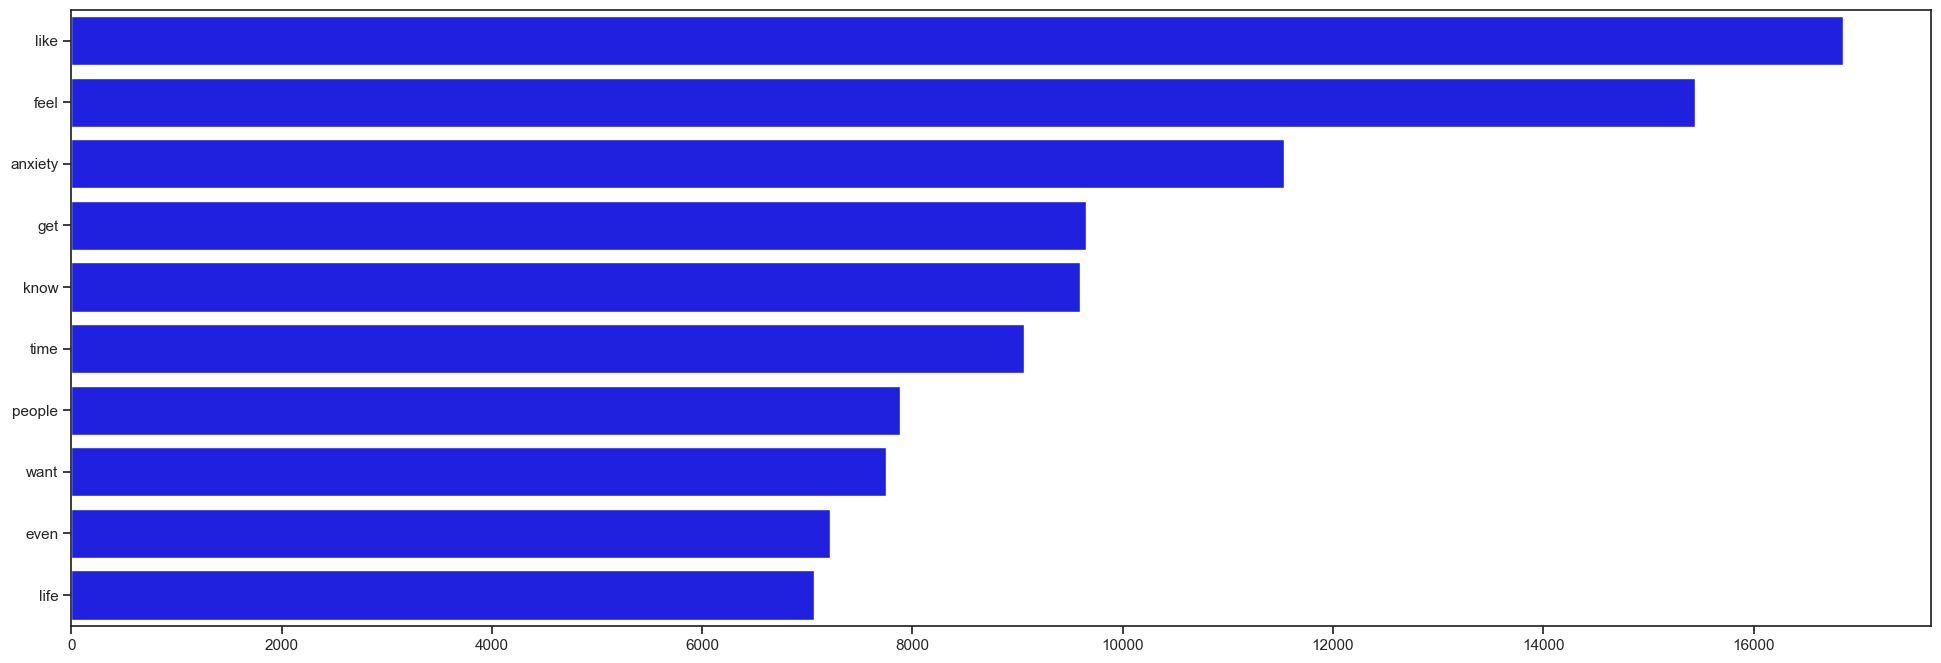

In [20]:
# plot common words in the frequency list

top_words = frequency.most_common(10)
top_words_df = pd.Series(dict(top_words))

plt.figure(figsize = (24,8))

sns.set_theme(style="ticks")
sns.barplot(y=top_words_df.index, x=top_words_df.values, color='blue')

plt.show()

### SentiWordNet Lexicon

In [21]:
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

make_sentences(df,'tokens')

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue
1,i can’t believe it,believe,believe,believe
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt


In [22]:
pos=neg=obj=count=0

postagging = []

for review in df['tokens']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

df['pos_tags'] = postagging

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i..."
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]"
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (..."
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder..."
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]"


In [23]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []
    
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0

senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  
            neg = neg + score[2]  
        except:
            continue
    senti_score.append(round((pos - neg),2))
    pos=neg=0    
    
df['senti_score'] = senti_score

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",0.12
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",0.00
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",0.00
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",2.50
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",-0.50


In [24]:
df['senti_score'].value_counts()

senti_score
 0.00     7820
-0.12     1955
 0.12     1811
 0.50     1086
-0.62     1051
          ... 
 2.89        1
 13.12       1
 2.42        1
 16.38       1
-5.27        1
Name: count, Length: 258, dtype: int64

In [25]:
df['senti_score'] = np.where(df['senti_score'] < 0, 'Negative', np.where(df['senti_score'] == 0.00, 'Neutral', 'Positive'))
df['senti_score'].value_counts()

senti_score
Negative    11215
Positive    10491
Neutral      7820
Name: count, dtype: int64

#### TextBlob

In [26]:
from textblob import TextBlob

def sentiment_analysis(df):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity
    
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    df['TextBlob_Subjectivity'] = df['text'].apply(getSubjectivity)
    df['TextBlob_Polarity'] = df['text'].apply(getPolarity)

    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'
        
    df['TextBlob_Analysis'] = df['TextBlob_Polarity'].apply(getAnalysis )

    return df

sentiment_analysis(df)

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.000000,Neutral
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.000000,Neutral
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.000000,Neutral
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.022230,Positive
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
29521,hi all! thank you so much for the participatio...,hi thank much participation far study looking ...,hi thank much participation far study looking ...,hi thank much participation far study looking ...,"[(hi, NN), (thank, NN), (much, JJ), (participa...",Positive,0.554762,0.109524,Positive
29522,am thots,thots,,,[],Neutral,0.000000,0.000000,Neutral
29523,i'm just reflecting on life a bit i utterly de...,reflecting life bit utterly despise fact matte...,reflecting life bit utterly despise fact matte...,reflecting life bit utterly despise fact matte...,"[(reflecting, VBG), (life, NN), (bit, RB), (ut...",Positive,0.549123,0.213596,Positive
29524,social anxiety is ruining my chances at findin...,social anxiety ruining chance finding career f...,social anxiety ruining chance finding career f...,social anxiety ruining chance finding career f...,"[(social, JJ), (anxiety, NN), (ruining, VBG), ...",Positive,0.183333,-0.141667,Negative


In [27]:
df['TextBlob_Analysis'].value_counts()

TextBlob_Analysis
Neutral     10371
Positive     9957
Negative     9198
Name: count, dtype: int64

### Polarity for Preprocessed Text with removal

In [28]:
# Sentiment Analysis Analyzer

from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df['polarity'] = df['preprocessed-text-removal'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,polarity
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp..."
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,"{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'comp..."
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,"{'neg': 0.255, 'neu': 0.545, 'pos': 0.2, 'comp..."
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,"{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'comp..."


In [29]:
# change polarity to seperate columns

df = pd.concat(
    [df.drop(['polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,neg,neu,pos,compound
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,0.000,0.476,0.524,0.5106
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,0.000,1.000,0.000,0.0000
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,0.437,0.563,0.000,-0.4767
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,0.255,0.545,0.200,-0.9538
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,0.677,0.323,0.000,-0.2732


In [30]:
# change compound to sentiment

df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,neg,neu,pos,compound,sentiment
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,0.000,0.476,0.524,0.5106,positive
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,0.000,1.000,0.000,0.0000,neutral
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,0.437,0.563,0.000,-0.4767,negative
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,0.255,0.545,0.200,-0.9538,negative
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,0.677,0.323,0.000,-0.2732,negative


In [31]:
print(df['sentiment'].value_counts())

sentiment
negative    13865
positive     9304
neutral      6357
Name: count, dtype: int64


### Polarity for Preprocessed Text (without removal)

In [32]:
df['polarity_without_removal'] = df['preprocessed-text'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,neg,neu,pos,compound,sentiment,polarity_without_removal
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,0.000,0.476,0.524,0.5106,positive,"{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp..."
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,0.000,1.000,0.000,0.0000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,0.437,0.563,0.000,-0.4767,negative,"{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'comp..."
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,0.255,0.545,0.200,-0.9538,negative,"{'neg': 0.252, 'neu': 0.549, 'pos': 0.198, 'co..."
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,0.677,0.323,0.000,-0.2732,negative,"{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'comp..."


In [33]:
# change polarity_without_removal to seperate columns

df = pd.concat(
    [df.drop(['polarity_without_removal','neg','neu','pos','compound'], axis=1), 
     df['polarity_without_removal'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,sentiment,neg,neu,pos,compound
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,positive,0.000,0.476,0.524,0.5106
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,neutral,0.000,1.000,0.000,0.0000
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,negative,0.437,0.563,0.000,-0.4767
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,negative,0.252,0.549,0.198,-0.9538
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,negative,0.677,0.323,0.000,-0.2732


In [34]:
# change compound to sentiment_without_removal

df['sentiment_without_removal'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df = df.drop(['neg','neu','pos','compound'], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,sentiment,sentiment_without_removal
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,positive,positive
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,neutral,neutral
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,negative,negative
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,negative,negative
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,negative,negative


In [35]:
print(df['sentiment_without_removal'].value_counts())

sentiment_without_removal
negative    13883
positive     9319
neutral      6324
Name: count, dtype: int64


### Polarity for Original Text

In [36]:
df['polarity_original'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,sentiment,sentiment_without_removal,polarity_original
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,positive,positive,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,neutral,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,negative,negative,"{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compou..."
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,negative,negative,"{'neg': 0.199, 'neu': 0.677, 'pos': 0.124, 'co..."
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,negative,negative,"{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'comp..."


In [37]:
# change polarity_original to seperate columns

df = pd.concat(
    [df.drop(['polarity_original'], axis=1), 
     df['polarity_original'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,sentiment,sentiment_without_removal,neg,neu,pos,compound
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,positive,positive,0.000,0.645,0.355,0.5106
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,neutral,neutral,0.000,1.000,0.000,0.0000
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,negative,negative,0.220,0.780,0.000,-0.4767
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,negative,negative,0.199,0.677,0.124,-0.9905
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,negative,negative,0.677,0.323,0.000,-0.2732


In [38]:
# change compound to sentiment_original

df['sentiment_original'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df = df.drop(['neg','neu','pos','compound'], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,sentiment,sentiment_without_removal,sentiment_original
0,my therapist told me i have trust issues,therapist told trust issue,therapist told trust issue,therapist told trust issue,"[(therapist, NN), (told, VBD), (trust, JJ), (i...",Positive,0.000000,0.00000,Neutral,positive,positive,positive
1,i can’t believe it,believe,believe,believe,"[(believe, VB)]",Neutral,0.000000,0.00000,Neutral,neutral,neutral,neutral
2,i think the internet ruined me and i don't kno...,think internet ruined know anymore,think internet ruined know anymore,think internet ruined know anymore,"[(think, VB), (internet, NN), (ruined, VBN), (...",Neutral,0.000000,0.00000,Neutral,negative,negative,negative
3,hi i'm m and for the longest time i was wonder...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,hi longest time wondering enjoy anything anymo...,"[(hi, NN), (longest, JJS), (time, NN), (wonder...",Positive,0.602344,0.02223,Positive,negative,negative,negative
4,masturbation guilt,masturbation guilt,masturbation guilt,masturbation guilt,"[(masturbation, NN), (guilt, NN)]",Negative,0.000000,0.00000,Neutral,negative,negative,negative


In [39]:
print(df['sentiment_original'].value_counts())

sentiment_original
negative    14406
positive     8778
neutral      6342
Name: count, dtype: int64


We will use the original text polarity since it retains most of the meaning and has the highest percentage of negative comments since they are scraped mostly from mental disorder pages.

In [ ]:
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             )

In [ ]:
df.shape

In [40]:
from datetime import date
today = date.today()

In [ ]:
final_df = df[['preprocessed-text-removal', 'sentiment']]
final_df['sentiment'] = np.where(final_df['sentiment'] == 'positive', 2, np.where(final_df['sentiment'] == 'negative', 1, 0)).astype(int)
final_df.to_csv('../Reddit Data/final_dataset_encoded_{}.csv'.format(today))

In [41]:
final_df = df[['preprocessed-text-removal', 'sentiment']]
final_df.to_csv('../Reddit Data/final_dataset_{}.csv'.format(today))

In [ ]:
final_df_text = df[['preprocessed-text-removal']]
final_df_text.to_csv('../Reddit Data/final_dataset_{}.csv'.format(today))

In [ ]:
final_df.sentiment.unique()

In [ ]:
for sentiments in final_df.sentiment.unique():
    df_2 = final_df[final_df['sentiment']==sentiments]['preprocessed-text-removal']
    df_2.to_csv('../Reddit Data/Sentiment/{}.txt'.format(sentiments), sep='\t', index=False, header=False)

In [ ]:
final_df.head()

In [ ]:
sentiment_text_dict = {}

for index, row in final_df.iterrows():
    sentiment = row['sentiment']
    text = row['preprocessed-text-removal']
    
    if sentiment in sentiment_text_dict:
        sentiment_text_dict[sentiment].append(text)
    else:
        sentiment_text_dict[sentiment] = [text]

print(sentiment_text_dict)


In [ ]:
intent = {}
intent['intents'] = []

for key, value in sentiment_text_dict.items():
    df_dict = {}
    df_dict['tag'] = key
    df_dict['patterns'] = []
    df_dict['patterns'].append(value)
    if key == 'neutral':
        df_dict['responses'] = ['You are okay']
    if key == 'negative':
        df_dict['responses'] = ['You have depression']
    if key == 'positive':
        df_dict['responses'] = ['You are very happy']
    intent['intents'].append(df_dict)

print(intent)

In [ ]:
import json
file_path = '../Chatbot/sentiment_text_dict.json'

with open(file_path, 'w') as json_file:
    json.dump(intent, json_file)

print(f"Dictionary saved as JSON file: {file_path}")
